<div style="background-color: #82f6c9; padding: 10px;">
<div style="text-align: center;">
<h1>
Efficient Supply Allocation - Bolt
</h1>
<h2>
Candidate: Nilanjan Haldar
</h2>
Date: 10.02.2024

</div>
<h2>Task details</h2>


1. Explore the data and suggest a solution to guide the drivers towards areas with higher expected demand at given time and location
2. Build and document a baseline model for your solution
3. Describe how you would design and deploy such a model
4. Describe how to communicate model recommendations to drivers
5. Think through and describe the design of the experiment that would validate your solution for live operations taking into account marketplace specifics

<h2>How to read this notebook</h2>

1. The notebook is divided into four parts-
   1. Data preparation
   2. Data analysis
      1. Time and demand analysis
      2. Demand, ride value and location analysis
   3. Demand Modeling
   4. Business Application
3. Before each code cells containing scripts of a plot, the green markdown describes it shortly.
4. At the end of each section, a summary of findings highlighted in green background is there.
</div>

In [1]:
#!pip install pandas
import pandas as pd
import numpy as np

#!pip install seaborn
import seaborn as sns
palette = ["#24f0a0", "#82f6c9", "#25765d"] # Brand colour codes extracted from here: https://colorswall.com/palette/33575
sns.set_palette(palette)

#!pip install matplotlib
import matplotlib.pyplot as plt

import time
import calendar

#!pip install geopy
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

#!pip install folium
import folium
from folium import plugins
from folium.plugins import HeatMap

#!pip install -U scikit-learn scipy matplotlib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import pickle

import warnings
warnings.filterwarnings('ignore')

/var/folders/hl/4kr94_250jq3v1lj0b_6r5380000gp/T/ipykernel_22326/2659584023.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<div style="background-color: #82f6c9; padding: 1px;">
<h3>Section 1. Data Preparation</h3>
</div>

In [2]:
## Load dataset

raw_data = pd.read_csv('robotex5.csv')
raw_data

start_time  start_lat  start_lng    end_lat  \
0       2022-03-06 15:02:39.329452000  59.407910  24.689836  59.513027   
1       2022-03-10 11:15:55.177526000  59.441650  24.762712  59.426450   
2       2022-03-06 14:23:33.893257000  59.435404  24.749795  59.431901   
3       2022-03-03 09:11:59.104192000  59.406920  24.659006  59.381093   
4       2022-03-06 00:13:01.290346000  59.434940  24.753641  59.489203   
...                               ...        ...        ...        ...   
627205  2022-03-16 06:19:39.281000000  59.489132  24.870559  59.426810   
627206  2022-03-12 08:33:15.949213000  59.428616  24.771929  59.439053   
627207  2022-03-16 06:20:33.475000000  59.387015  24.705160  59.422822   
627208  2022-03-10 01:08:17.750884000  59.441934  24.754971  59.437759   
627209  2022-03-20 21:05:49.697505000  59.439201  24.761567  59.426927   

          end_lng  ride_value  
0       24.831630    3.518250  
1       24.783076    0.507500  
2       24.761588    0.190250  
3       24.641652    0.756000  
4       24.876170    2.271000  
...           ...         ...  
627205  24.672892    3.232051  
627206  24.873362    1.436750  
627207  24.697156    0.993888  
627208  24.775483    0.307250  
627209  24.552130    2.925750  

[627210 rows x 6 columns]

In [3]:
print(raw_data.isna().sum())
print('----------------')

## Double checking if there are any empty strings in any cells
data = raw_data.copy()
data = data.replace(r'^\s*$', np.nan, regex=True)
print(data.isna().sum())

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64
----------------
start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64


<font color='#098f5a'>

1. Only start_time field type needs to be changed, the rest looks good.
2. The dataset does not seem to have any missing values.
</font>

In [4]:
data.dtypes

start_time     object
start_lat     float64
start_lng     float64
end_lat       float64
end_lng       float64
ride_value    float64
dtype: object

<font color='#098f5a'>

1. Only start_time field type needs to be changed, the rest looks good.
2. The ride_value seems to have outliers, so does the end_lat and end_lng.
</font>

In [5]:
data.describe()

start_lat      start_lng        end_lat        end_lng  \
count  627210.000000  627210.000000  627210.000000  627210.000000   
mean       59.428682      24.743468      59.397797      24.724847   
std         0.021764       0.056872       1.392755       1.650709   
min        59.321557      24.505199     -37.819979    -122.453962   
25%        59.418803      24.713140      59.415215      24.707919   
50%        59.432069      24.744674      59.430697      24.744335   
75%        59.439024      24.768115      59.439262      24.773924   
max        59.566998      24.973743      61.552744     144.966110   

          ride_value  
count  627210.000000  
mean        2.261384  
std        44.889892  
min         0.107628  
25%         0.545250  
50%         1.059000  
75%         1.712000  
max      3172.701000

<font color='#098f5a'>
    
1. Based on the initial look, the time field could be used to create some derrived attributes like hour, mins of the day, and also if the day can be split into multiple sections.
2. To extract the day of the week could also makes sense to understand demand correlation with specific days and time.
3. Ride value is too granular, could be rounded up.
4. Also distance could be calculated from the lat and lng to understand the relation between ride_value and distance, and whether surge prices are applicable to this case or not.
</font>

In [6]:
## Creating new features out of start_time
data['start_time'] = pd.to_datetime(data['start_time'])

data['date'] = data['start_time'].dt.date
data['time'] = data['start_time'].dt.time

data['hours'] = data['start_time'].dt.hour
data['minutes'] = data['start_time'].dt.minute

data['day_split'] = pd.cut(data['hours'], bins=[-1,6,12,18,24], labels=[1,2,3,4])

data['weekday'] = data['start_time'].dt.weekday
data['weekend'] = data['weekday'].apply(lambda x: 1 if x>4 else 0)

## Calculating distance between start and end locations using geodesic distance
def calculate_geodesic(row):
    start_coords = (row['start_lat'], row['start_lng'])
    end_coords = (row['end_lat'], row['end_lng'])
    return round(geodesic(start_coords, end_coords).km, 2)

# Apply the function to create a new column 'geodesic_distance'
data['distance_kms'] = data.apply(calculate_geodesic, axis=1)


In [7]:
## This part is commented out, since there are issues with the free API 

## Extracting zipcode based on start_lat and start_lng
## More details about the package here: https://geopy.readthedocs.io/en/latest/index.html

# initialize the geolocator
'''
import certifi
import ssl
import geopy.geocoders
from geopy.geocoders import Nominatim
ctx = ssl.create_default_context(cafile=certifi.where())
geopy.geocoders.options.default_ssl_context = ctx

geolocator = Nominatim(user_agent="my_geocoder")

def extract_postcode(row):
    start_coords = (row['start_lat'], row['start_lng'])
    # Reverse geocode to get the address details
    location_info = geolocator.reverse(start_coords, language='en', timeout=10)
    # Extract the postcode
    postcode = location_info.raw.get('address', {}).get('postcode', None)
    return postcode

data_1000 = data.head(1000)
# Apply the function to create a new column 'geodesic_distance'
data_1000['start_postcode'] = data_1000.apply(extract_postcode, axis=1)
'''

'\nimport certifi\nimport ssl\nimport geopy.geocoders\nfrom geopy.geocoders import Nominatim\nctx = ssl.create_default_context(cafile=certifi.where())\ngeopy.geocoders.options.default_ssl_context = ctx\n\ngeolocator = Nominatim(user_agent="my_geocoder")\n\ndef extract_postcode(row):\n    start_coords = (row[\'start_lat\'], row[\'start_lng\'])\n    # Reverse geocode to get the address details\n    location_info = geolocator.reverse(start_coords, language=\'en\', timeout=10)\n    # Extract the postcode\n    postcode = location_info.raw.get(\'address\', {}).get(\'postcode\', None)\n    return postcode\n\ndata_1000 = data.head(1000)\n# Apply the function to create a new column \'geodesic_distance\'\ndata_1000[\'start_postcode\'] = data_1000.apply(extract_postcode, axis=1)\n'

In [8]:
data.head(5)

start_time  start_lat  start_lng    end_lat    end_lng  \
0 2022-03-06 15:02:39.329452  59.407910  24.689836  59.513027  24.831630   
1 2022-03-10 11:15:55.177526  59.441650  24.762712  59.426450  24.783076   
2 2022-03-06 14:23:33.893257  59.435404  24.749795  59.431901  24.761588   
3 2022-03-03 09:11:59.104192  59.406920  24.659006  59.381093  24.641652   
4 2022-03-06 00:13:01.290346  59.434940  24.753641  59.489203  24.876170   

   ride_value        date             time  hours  minutes day_split  weekday  \
0     3.51825  2022-03-06  15:02:39.329452     15        2         3        6   
1     0.50750  2022-03-10  11:15:55.177526     11       15         2        3   
2     0.19025  2022-03-06  14:23:33.893257     14       23         3        6   
3     0.75600  2022-03-03  09:11:59.104192      9       11         2        3   
4     2.27100  2022-03-06  00:13:01.290346      0       13         1        6   

   weekend  distance_kms  
0        1         14.21  
1        0          2.05  
2        1          0.77  
3        0          3.04  
4        1          9.21

<div style="background-color: #82f6c9; padding: 1px;">
<h2>Section 2. Data Analysis</h2>
This sections attempts to find if there are any abnormalities such as outliers in the dataset, and define how to deal with those along with finding patterns in the data that could result in business decisions.
</div>

<h3> 2.1 Time and demand anaylsis</h3>

**It seems the data is available only for the month of March, 2022.
And according to this [source](https://www.officeholidays.com/countries/estonia/2022), there were no public holidays in Estonia that might create abnormal traffic. If this was not the case, then "holidays" package can be used to create a derrived feature.**

In [9]:
print('Min date: ', data.date.min())
print('Max date: ', data.date.max())

Min date:  2022-03-01
Max date:  2022-03-28


<font color='#098f5a'>
Initial time and demand analysis shows the following:

***On daily aggregated demand level***, there isn't any distinct pattern, except, Sunday (6) and Monday (0) seems to have less demand compare to rest of the weekdays.
</font>

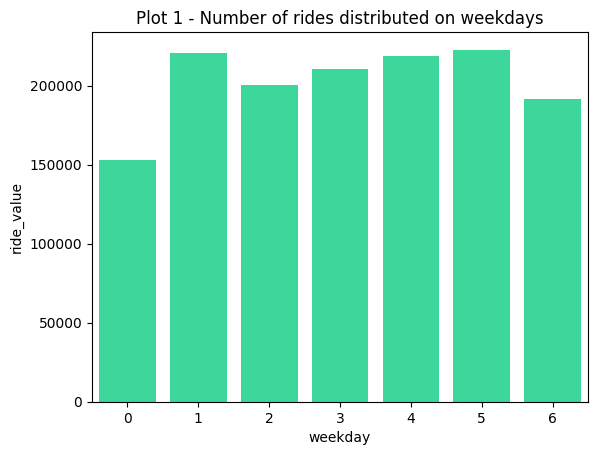

In [10]:
demand_daily = pd.DataFrame(data.groupby('weekday')['ride_value'].sum()).reset_index()  
sns.barplot(x="weekday", y="ride_value", data=demand_daily)
plt.title('Plot 1 - Number of rides distributed on weekdays')
plt.show()

In [11]:
## Checking if there are any pattern if the data is broken down on week level

## Extracting ISO week number from date
data['week_number'] = data['start_time'].dt.isocalendar().week
data['week_number'].unique()

<IntegerArray>
[9, 10, 11, 12, 13]
Length: 5, dtype: UInt32

In [12]:
print(data[data['week_number']==9].shape)
print(data[data['week_number']==10].shape)
print(data[data['week_number']==11].shape)
print(data[data['week_number']==12].shape)
print(data[data['week_number']==13].shape)

week1 = data[data['week_number']==9]
week2 = data[data['week_number']==10]
week3 = data[data['week_number']==11]
week4 = data[data['week_number']==12]

(120247, 15)
(146541, 15)
(161622, 15)
(178460, 15)
(20340, 15)


<font color='#098f5a'>
Weekly breakdown of time and demand analysis shows the following:

***When filtered for each week, the daily aggregated demand level***, there is not any distinct pattern that repeats every week, except the fact the Mondays seems to draw less demand.
</font>

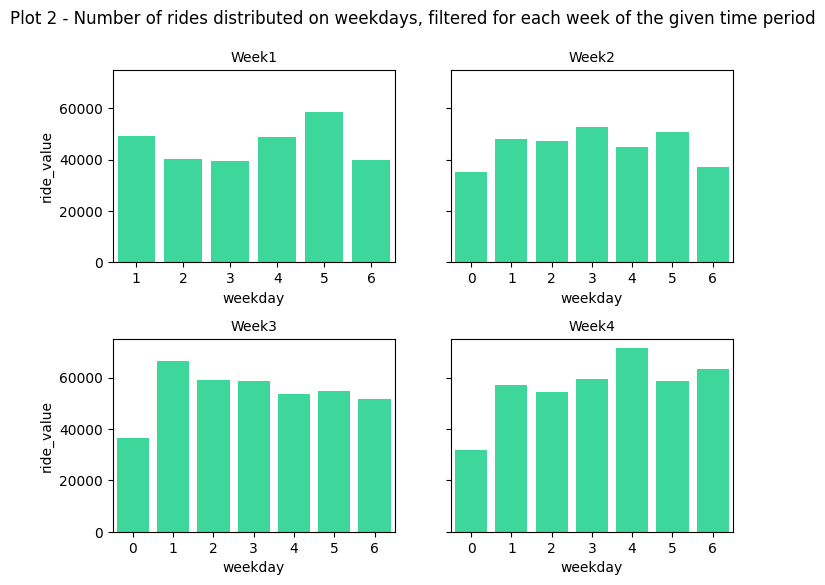

In [13]:
demand_daily_week1 = pd.DataFrame(week1.groupby('weekday')['ride_value'].sum()).reset_index()
demand_daily_week2 = pd.DataFrame(week2.groupby('weekday')['ride_value'].sum()).reset_index()
demand_daily_week3 = pd.DataFrame(week3.groupby('weekday')['ride_value'].sum()).reset_index()
demand_daily_week4 = pd.DataFrame(week4.groupby('weekday')['ride_value'].sum()).reset_index()

fig, axs = plt.subplots(2,2, sharey=True, figsize = (8,6), gridspec_kw={'hspace': 0.4})
axs[0][0].set_title('Week1', fontsize=10)
sns.barplot(x="weekday", y="ride_value", data=demand_daily_week1, ax=axs[0][0])
axs[0][1].set_title('Week2', fontsize=10)
sns.barplot(x="weekday", y="ride_value", data=demand_daily_week2, ax=axs[0][1])
axs[1][0].set_title('Week3', fontsize=10)
sns.barplot(x="weekday", y="ride_value", data=demand_daily_week3, ax=axs[1][0])
axs[1][1].set_title('Week4', fontsize=10)
sns.barplot(x="weekday", y="ride_value", data=demand_daily_week4, ax=axs[1][1])

plt.suptitle('Plot 2 - Number of rides distributed on weekdays, filtered for each week of the given time period')
plt.show()

<font color='#098f5a'>

***The weekday and hour heatmap shows the following:***

1. Night time (1am-4am) through out the week seems to be least busy.
3. Monday and Sunday shows similar pattern where the demand slacks off after morning and afternoon rush hours (9:00 - 12:00 & 17:00 - 20:00)
4. Usual peak demand happens during rush hours (6:00-8:00 & 14:00-17:00) from Tuesday to Friday, which could be due to work related trips.
5. The demand shifts toward evening during weekend. For example: Saturday evening seems to be the bussiest (20:00-24:00) apart from standard rush hours and follows by Sunday evening.
6. ***Also when looked into each week individually, the demand pattern stays the same.***
</font>

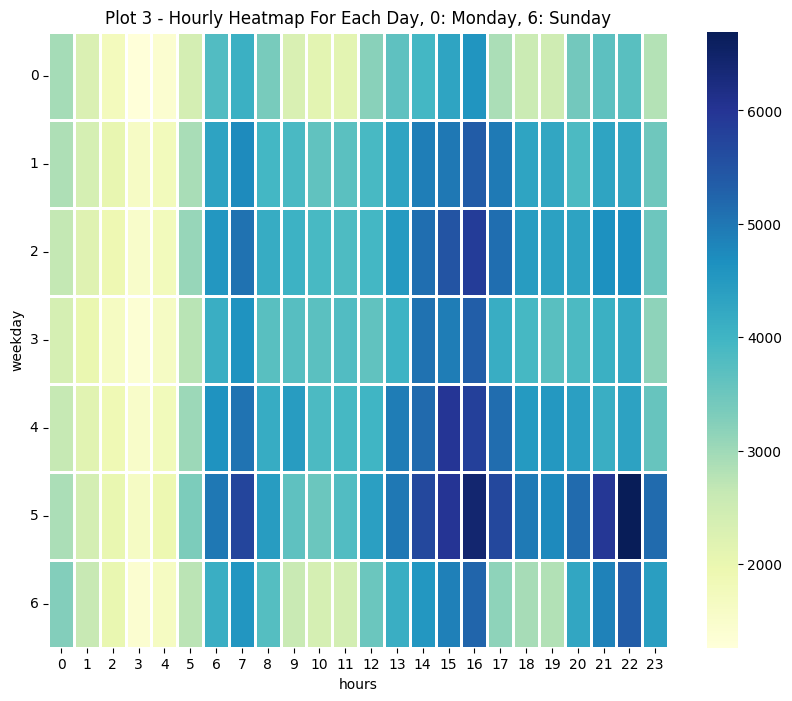

In [14]:
data_heat = data.groupby(['weekday', 'hours']).size().reset_index()
data_heat.columns = ['weekday', 'hours', 'Hourly Count']

# plot data to show hourly request heatmap
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(data_heat.pivot(index= 'weekday', columns= 'hours', values='Hourly Count'), cmap="YlGnBu", linewidth=1)
plt.yticks(rotation=0)
plt.title('Plot 3 - Hourly Heatmap For Each Day, 0: Monday, 6: Sunday')
plt.show()

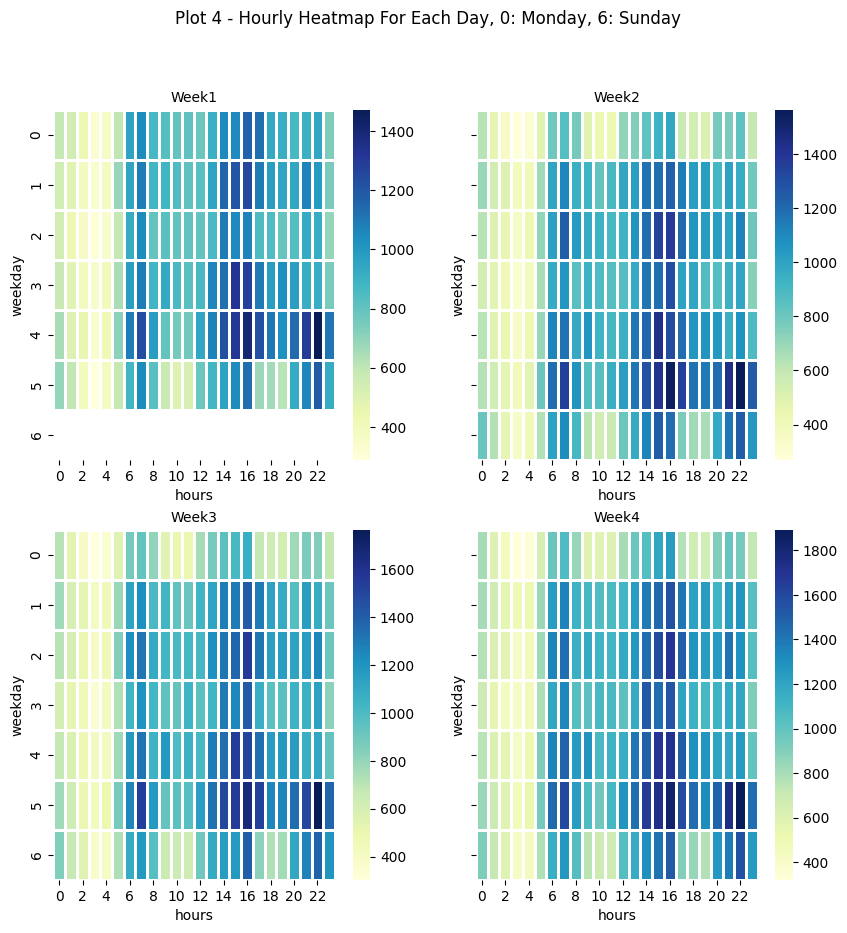

In [15]:
data_heat_w1 = week1.groupby(['weekday', 'hours']).size().reset_index()
data_heat_w1.columns = ['weekday', 'hours', 'Hourly Count']
data_heat_w2 = week2.groupby(['weekday', 'hours']).size().reset_index()
data_heat_w2.columns = ['weekday', 'hours', 'Hourly Count']
data_heat_w3 = week3.groupby(['weekday', 'hours']).size().reset_index()
data_heat_w3.columns = ['weekday', 'hours', 'Hourly Count']
data_heat_w4 = week4.groupby(['weekday', 'hours']).size().reset_index()
data_heat_w4.columns = ['weekday', 'hours', 'Hourly Count']

# plot data to show hourly request heatmap
fig, axs = plt.subplots(2,2, sharey=True, figsize = (10,10), gridspec_kw={'hspace': 0.2})

axs[0][0].set_title('Week1', fontsize=10)
sns.heatmap(data_heat_w1.pivot(index= 'weekday', columns= 'hours', values='Hourly Count'), cmap="YlGnBu", linewidth=1, ax=axs[0][0])
#sns.barplot(x="weekday", y="ride_value", data=demand_daily_week1, ax=axs[0][0])

axs[0][1].set_title('Week2', fontsize=10)
sns.heatmap(data_heat_w2.pivot(index= 'weekday', columns= 'hours', values='Hourly Count'), cmap="YlGnBu", linewidth=1, ax=axs[0][1])

axs[1][0].set_title('Week3', fontsize=10)
sns.heatmap(data_heat_w3.pivot(index= 'weekday', columns= 'hours', values='Hourly Count'), cmap="YlGnBu", linewidth=1, ax=axs[1][0])

axs[1][1].set_title('Week4', fontsize=10)
sns.heatmap(data_heat_w4.pivot(index= 'weekday', columns= 'hours', values='Hourly Count'), cmap="YlGnBu", linewidth=1, ax=axs[1][1])

# Set a title for the entire plot
plt.suptitle('Plot 4 - Hourly Heatmap For Each Day, 0: Monday, 6: Sunday', fontsize=12)

plt.show()

<div style="background-color: #82f6c9; padding: 1px;">

***Following insights could be derived after analysis of time and demand***

1. Monday seems to draw lesser demand in comparison to other weekdays **(Plot 1)**.
2. Demand betweeen Tuesday-Friday is similar throughout the day **(Plot 1, 2)**.
3. Night time (1am-4am) through out the week seems to be the least busiest **(Plot 3)**.
4. Weekends' evening demand is higher (18-24 hours) compared to the weekdays' demand **(Plot 3)**.
5. Demand on Sunday is similar to Monday till the evening, after that its demand is more particularly in between 18-24 hours
6. Possible hour buckets could be (0, 6), (6, 12), (12, 18) (18, 24) in hours.
7. It makes sense to keep the following derrived attributes for the model:
   1. weekday
   2. hours
   3. is_weekend
   4. day split (consists of the hour buckets as mentioned in point 6)
  
</div>

<h3>2.2 Demand, ride value and location anaylsis</h3>

<font color='#098f5a'>

From initial look, it seems like the ride_value and distance have execessive numbers, could be outlier.
</font>

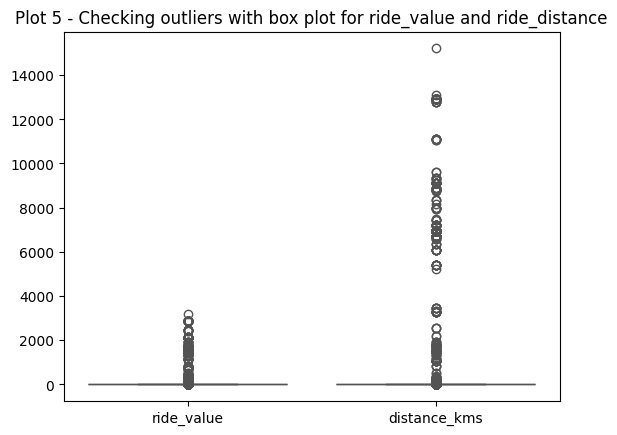

In [16]:
sns.boxplot(data[['ride_value', 'distance_kms']])
plt.title('Plot 5 - Checking outliers with box plot for ride_value and ride_distance')
plt.show()

<font color='#098f5a'>

Distribution of ride_value is right skewed, which shows that most of the values are close to 0.

</font>

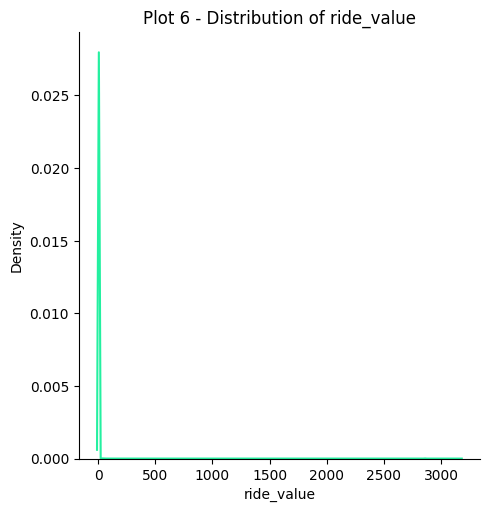

In [17]:
sns.displot(data, x="ride_value", kind="kde")
plt.title('Plot 6 - Distribution of ride_value')
plt.show()

In [18]:
print('Average ride value: ', round(data.loc[:, 'ride_value'].mean(), 2))
print('Median ride value: ', round(data.loc[:, 'ride_value'].median(), 2))
print('-------------')
print('Min ride value:', round(data['ride_value'].min(),2))
print('Max ride value:', round(data['ride_value'].max(),2))
print('-------------')
print('Average ride distance: ', round(data.loc[:, 'distance_kms'].mean(),2))
print('Median ride distance: ', round(data.loc[:, 'distance_kms'].median(), 2))
print('-------------')
print('Min ride distance:', round(data['distance_kms'].min(),2))
print('Max ride distance:', round(data['distance_kms'].max(),2))

Average ride value:  2.26
Median ride value:  1.06
-------------
Min ride value: 0.11
Max ride value: 3172.7
-------------
Average ride distance:  9.49
Median ride distance:  4.3
-------------
Min ride distance: 0.01
Max ride distance: 15209.15


<font color='#098f5a'>

The following table shows that majority of the ride values are less than 5.
<br>But the ride_value and distance scatter plot shows that there is a positive and strong correlation between those two. The idea of surge price (increased price for the same distance can be omited for now, since the data does not shows it.)

</font>

In [19]:
## Rounding up ride vaues to get an estimate of average frequencies
data['ride_value_round'] = np.ceil(data['ride_value'])

demand_daily = pd.DataFrame(data.groupby('ride_value_round').size()).reset_index()  
#sns.scatterplot(demand_daily)
demand_daily

ride_value_round       0
0                 1.0  297646
1                 2.0  218322
2                 3.0   78190
3                 4.0   24099
4                 5.0    5915
..                ...     ...
121            2859.0      14
122            2860.0      38
123            2861.0       4
124            2862.0       8
125            3173.0       1

[126 rows x 2 columns]

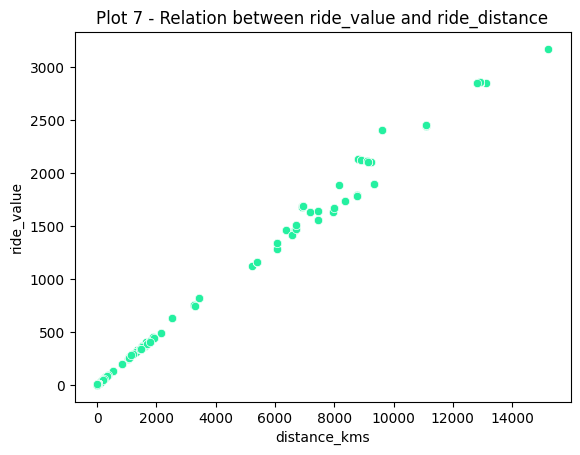

In [20]:
sns.scatterplot(data, x="distance_kms", y="ride_value")
plt.title('Plot 7 - Relation between ride_value and ride_distance')
plt.show()

<font color='#098f5a'>
Following distance breakdown shows that roughly aournd 2% of all journeys have a distance of more than 15 kms. So those will be treated as outliers for the intial analysis.
</font>

Trips with distance less than 5kms:  57.6%
Trips with distance between 5 and 10kms:  32.2%
Trips with distance between 10 and 15kms:  8.1%
Trips with distance between 15 and 20 kms:  1.6%
Trips with distance greater than 20kms:  0.5%


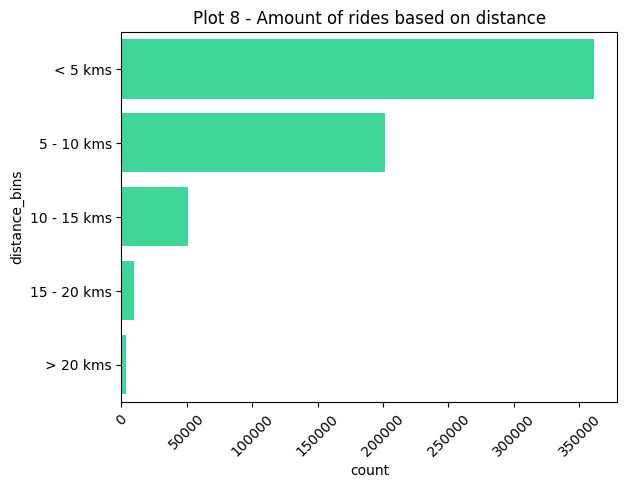

In [21]:
data['distance_bins'] = pd.cut(data['distance_kms'], bins = [0,5,10,15,20, 20000], labels = ['< 5 kms', '5 - 10 kms', '10 - 15 kms','15 - 20 kms', '> 20 kms'])
print("Trips with distance less than 5kms: ", str(round(data[data['distance_bins']=='< 5 kms'].shape[0]/data.shape[0] *100, 1))+'%') 
print("Trips with distance between 5 and 10kms: ", str(round(data[data['distance_bins']=='5 - 10 kms'].shape[0]/data.shape[0]*100, 1))+'%')
print("Trips with distance between 10 and 15kms: ", str(round(data[data['distance_bins']=='10 - 15 kms'].shape[0]/data.shape[0]*100, 1))+'%')
print("Trips with distance between 15 and 20 kms: ", str(round(data[data['distance_bins']=='15 - 20 kms'].shape[0]/data.shape[0]*100, 1))+'%')
print("Trips with distance greater than 20kms: ", str(round(data[data['distance_bins']=='> 20 kms'].shape[0]/data.shape[0]*100, 1))+'%')

distance_bins_plot = sns.countplot(data['distance_bins'])
fig =distance_bins_plot.set_xticklabels(distance_bins_plot.get_xticklabels(),rotation=45)
plt.title('Plot 8 - Amount of rides based on distance')
plt.show()

<font color='#098f5a'>
Removing all data points with distance more than 15 kms removed all the outliers both in ride_value and distance.
</font>

In [22]:
data_wo_outliers = data[data['distance_kms']<=15]

print('Average ride value: ', round(data_wo_outliers.loc[:, 'ride_value'].mean(), 2))
print('Median ride value: ', round(data_wo_outliers.loc[:, 'ride_value'].median(), 2))
print('-------------')
print('Min ride value:', round(data_wo_outliers['ride_value'].min(),2))
print('Max ride value:', round(data_wo_outliers['ride_value'].max(),2))
print('-------------')
print('Average ride distance: ', round(data_wo_outliers.loc[:, 'distance_kms'].mean(),2))
print('Median ride distance: ', round(data_wo_outliers.loc[:, 'distance_kms'].median(), 2))
print('-------------')
print('Min ride distance:', round(data_wo_outliers['distance_kms'].min(),2))
print('Max ride distance:', round(data_wo_outliers['distance_kms'].max(),2))

Average ride value:  1.18
Median ride value:  1.04
-------------
Min ride value: 0.11
Max ride value: 3.74
-------------
Average ride distance:  4.8
Median ride distance:  4.2
-------------
Min ride distance: 0.01
Max ride distance: 15.0


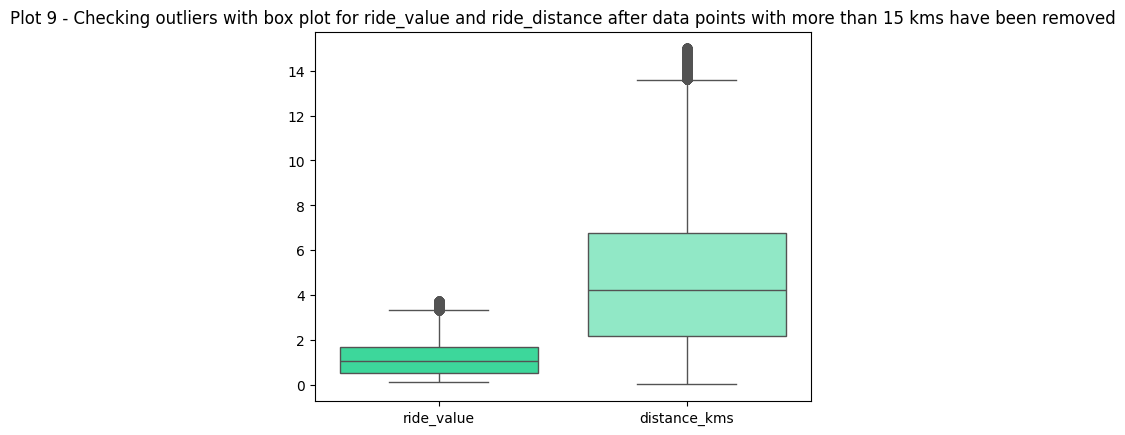

In [23]:
sns.boxplot(data_wo_outliers[['ride_value', 'distance_kms']])
plt.title('Plot 9 - Checking outliers with box plot for ride_value and ride_distance after data points with more than 15 kms have been removed')
plt.show()

<font color='#098f5a'>
There seems to be a linear relationship between ride_value and ride_distance. 
</font>

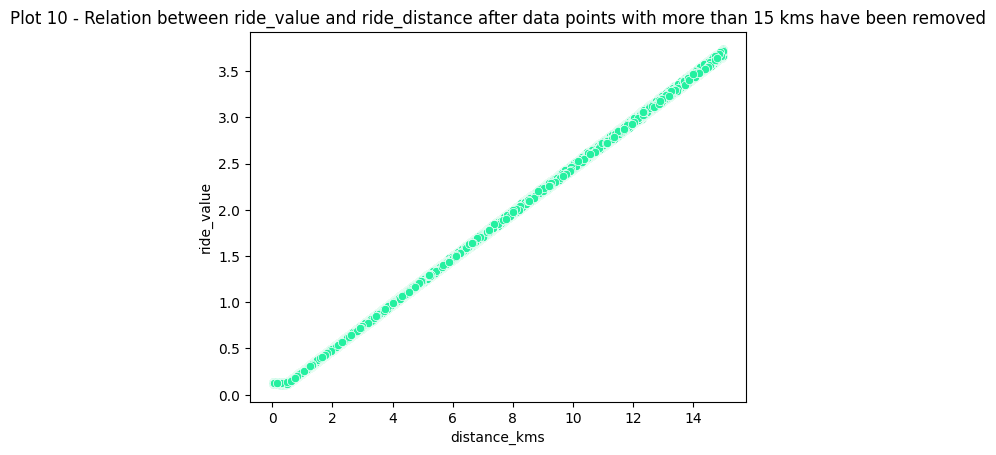

In [24]:
sns.scatterplot(data_wo_outliers, x="distance_kms", y="ride_value")
plt.title('Plot 10 - Relation between ride_value and ride_distance after data points with more than 15 kms have been removed')
plt.show()

<font color='#098f5a'>

***Start location analysis***

1. Due to high number of pick up points, the following plots do not show any distinct patterns over different times of the day. The start lat and lng could be rounded off to get more generic location.
2. Also, most of the shorter trips are centered towards the city centre. 

</font>

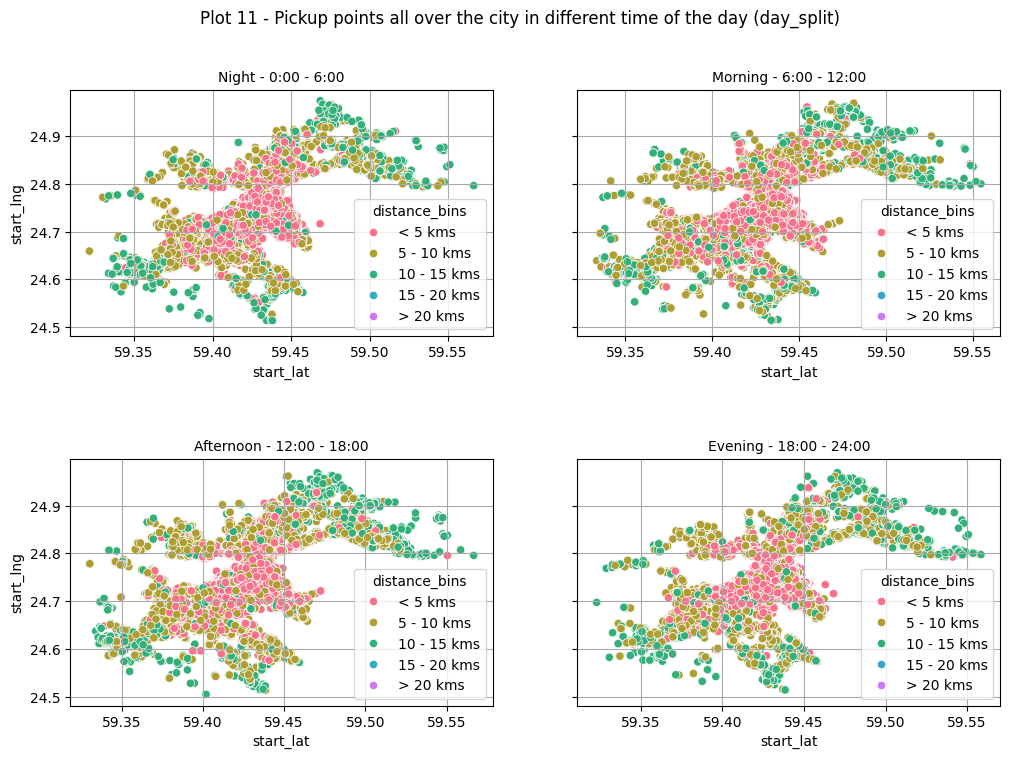

In [25]:
fig, axs = plt.subplots(2,2, sharey=True, figsize=(12,8), gridspec_kw={'hspace': 0.5})

axs[0][0].set_title('Night - 0:00 - 6:00', fontsize=10)
axs[0][0].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==1], y='start_lng', x='start_lat', hue='distance_bins', ax=axs[0][0])

axs[0][1].set_title('Morning - 6:00 - 12:00', fontsize=10)
axs[0][1].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==2], y='start_lng', x='start_lat', hue='distance_bins', ax=axs[0][1])

axs[1][0].set_title('Afternoon - 12:00 - 18:00', fontsize=10)
axs[1][0].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==3], y='start_lng', x='start_lat', hue='distance_bins', ax=axs[1][0])

axs[1][1].set_title('Evening - 18:00 - 24:00', fontsize=10)
axs[1][1].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==4], y='start_lng', x='start_lat', hue='distance_bins', ax=axs[1][1])

# Set a title for the entire plot
plt.suptitle('Plot 11 - Pickup points all over the city in different time of the day (day_split)', fontsize=12)
plt.show()


<font color='red'>

***According to this [source](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude), a 6 digit lat and lon has a precision of 11cm where as a 3 digit lat and lon has a precision of 110 m. So it makes sense to aggregate pick points on this granularity to have a clustered analysis.***

</font>


In [26]:
## Rouding off start lat and lng to three decimal points, precision 110 m

data_wo_outliers['start_lat_2'] = data_wo_outliers['start_lat'].round(3)
data_wo_outliers['start_lng_2'] = data_wo_outliers['start_lng'].round(3)

data_wo_outliers['start_location'] = list(zip(data_wo_outliers['start_lat_2'], data_wo_outliers['start_lng_2']))

print('Number of unique start location(agg):', data_wo_outliers['start_location'].nunique())
print('Number of unique exact start location: ', len(set(list(zip(data_wo_outliers['start_lat'], data_wo_outliers['start_lng'])))))

Number of unique start location(agg): 14129
Number of unique exact start location:  344914


<font color='#098f5a'>

***Aggregated pick up points (3 decimal places, 110m precision)***

1. Unfortunately this aggregation did not seem to create good patterns, since the number of data points are still too high
2. When rounded off to two decimal places, the location is not precise enough to show patterns

</font>

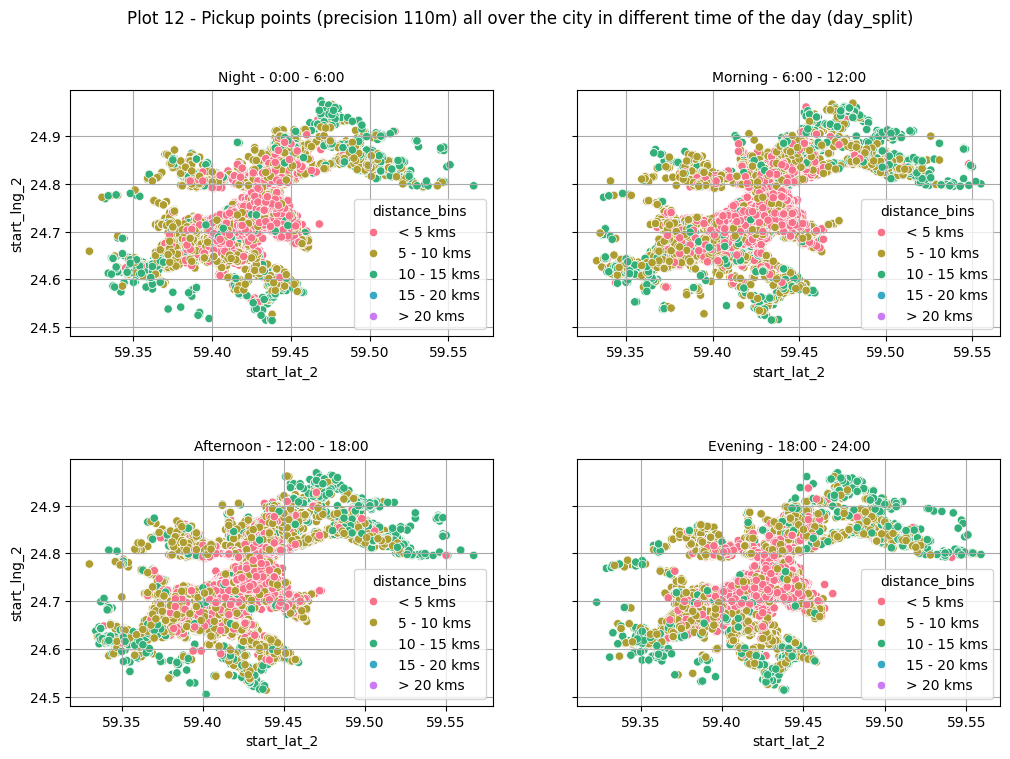

In [27]:
fig, axs = plt.subplots(2,2, sharey=True, figsize=(12,8), gridspec_kw={'hspace': 0.5})

axs[0][0].set_title('Night - 0:00 - 6:00', fontsize=10)
axs[0][0].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==1], y='start_lng_2', x='start_lat_2', hue='distance_bins', ax=axs[0][0])

axs[0][1].set_title('Morning - 6:00 - 12:00', fontsize=10)
axs[0][1].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==2], y='start_lng_2', x='start_lat_2', hue='distance_bins', ax=axs[0][1])

axs[1][0].set_title('Afternoon - 12:00 - 18:00', fontsize=10)
axs[1][0].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==3], y='start_lng_2', x='start_lat_2', hue='distance_bins', ax=axs[1][0])

axs[1][1].set_title('Evening - 18:00 - 24:00', fontsize=10)
axs[1][1].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==4], y='start_lng_2', x='start_lat_2', hue='distance_bins', ax=axs[1][1])

# Set a title for the entire plot
plt.suptitle('Plot 12 - Pickup points (precision 110m) all over the city in different time of the day (day_split)', fontsize=12)
plt.show()

<font color='#098f5a'>
There isn't a big difference either when the pickup points were compared between weekdays and weekend
</font>

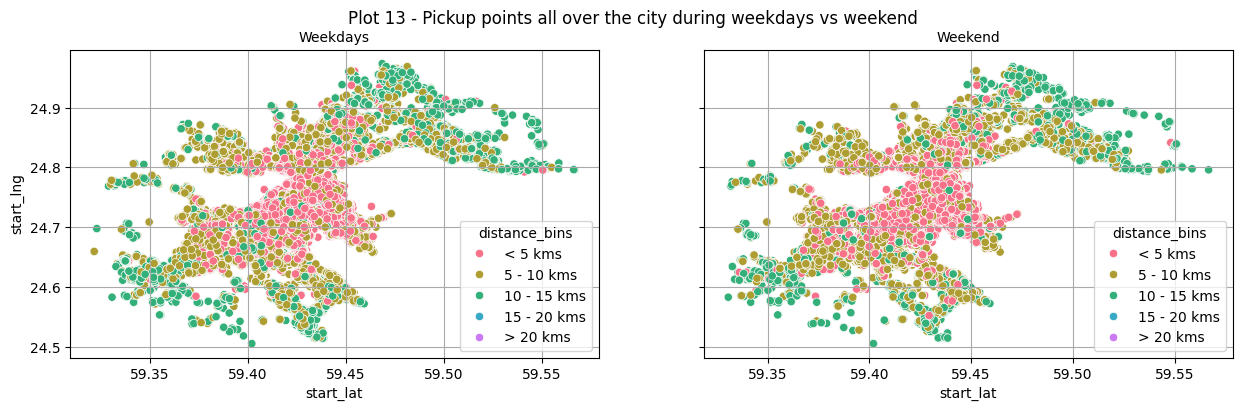

In [28]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(15,4), gridspec_kw={'hspace': 0.5})

axs[0].set_title('Weekdays', fontsize=10)
axs[0].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['weekend']==0], y='start_lng', x='start_lat', hue='distance_bins', ax=axs[0])
axs[1].set_title('Weekend', fontsize=10)
axs[1].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['weekend']==1], y='start_lng', x='start_lat', hue='distance_bins', ax=axs[1])

# Set a title for the entire plot
plt.suptitle('Plot 13 - Pickup points all over the city during weekdays vs weekend', fontsize=12)
plt.show()

<font color='#098f5a'>

1. The pickup points are quite dense in the city whereas there a lot of drop off points towards the outsirkts.
2. Further anaylsis needed to check how often the outskirts dropoff points happen and what is the economic and enviromental impact on the driver for returning to the city centre without passengers.
3. The plots also shows a lot of pickup and dropoff happens close to the city centre, further analysis deepdive with customer data could reveal how many of them are repeat customers and how often do they ride with Bolt. Based on that, special marketing offers could be created.
</font>

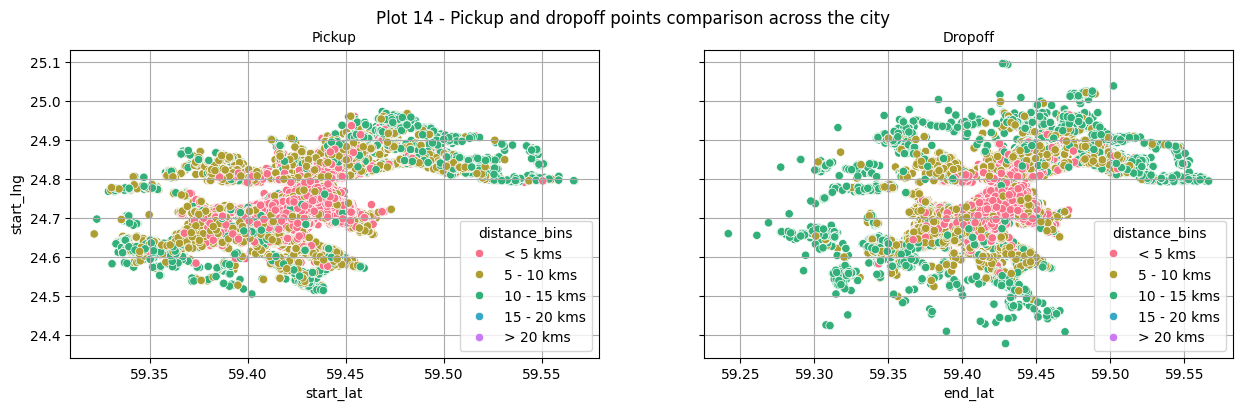

In [29]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(15,4), gridspec_kw={'hspace': 0.5})

axs[0].set_title('Pickup', fontsize=10)
axs[0].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers, y='start_lng', x='start_lat', hue='distance_bins', ax=axs[0])
axs[1].set_title('Dropoff', fontsize=10)
axs[1].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers, y='end_lng', x='end_lat', hue='distance_bins', ax=axs[1])

# Set a title for the entire plot
plt.suptitle('Plot 14 - Pickup and dropoff points comparison across the city', fontsize=12)
plt.show()

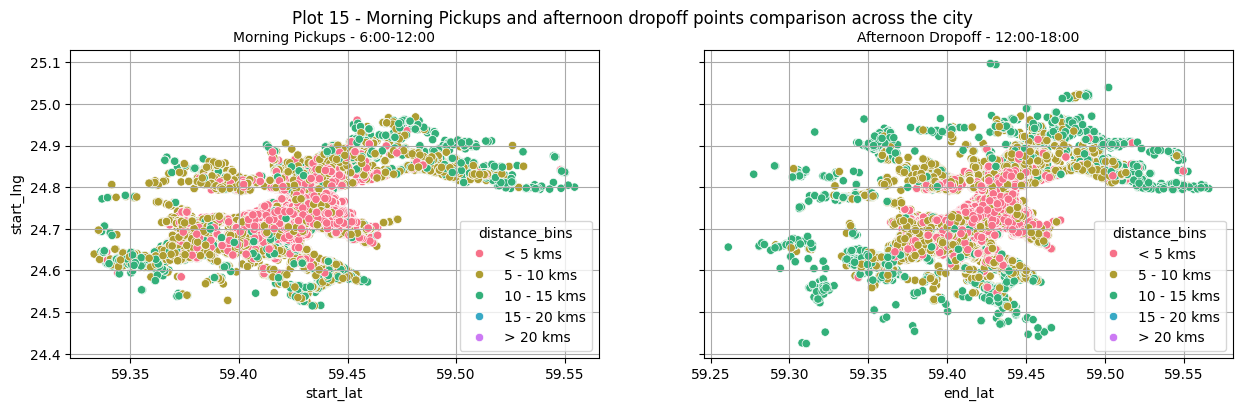

In [30]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(15,4), gridspec_kw={'hspace': 0.5})

axs[0].set_title('Morning Pickups - 6:00-12:00', fontsize=10)
axs[0].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==2], y='start_lng', x='start_lat', hue='distance_bins', ax=axs[0])
axs[1].set_title('Afternoon Dropoff - 12:00-18:00', fontsize=10)
axs[1].grid(True, color='darkgray')
start_location_plot = sns.scatterplot(data = data_wo_outliers[data_wo_outliers['day_split']==3], y='end_lng', x='end_lat', hue='distance_bins', ax=axs[1])

# Set a title for the entire plot
plt.suptitle('Plot 15 - Morning Pickups and afternoon dropoff points comparison across the city', fontsize=12)
plt.show()

<font color='#098f5a'>

***Demand anaylsis on pickup points***

1. The demand of certain pickup points close to the city centre is significantly higher than other places in the outskirts.
</font>

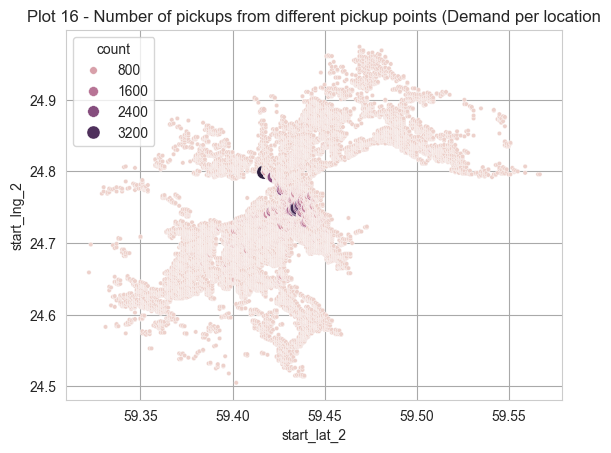

In [31]:
## Getting the demand per location (1.1 km)
pickup_demand = data_wo_outliers.groupby(['start_lat_2', 'start_lng_2']).size().reset_index(name='count')

# Set the grid color
sns.set_style("whitegrid", {'grid.color': 'darkgray'})
start_location_plot = sns.scatterplot(data = pickup_demand, y='start_lng_2', x='start_lat_2', size='count', sizes=(10, 100), hue='count')
plt.title('Plot 16 - Number of pickups from different pickup points (Demand per location')
plt.show()

The following folium interractive map showcase what could be possible with demand heatmap on the city map. Also time variant could be added that will show how the demand shifts over different locations during different hours of the day.

*But this is ignored due to limited time and effort for this task.*

In [32]:
week_1_data = data_wo_outliers[data_wo_outliers['week_number']==9]

# Create a folium map centered around the average latitude and longitude
center_lat = week_1_data['start_lat'].mean()
center_lng = week_1_data['start_lng'].mean()
mymap = folium.Map(location=[center_lat, center_lng], zoom_start=13)


# Create a HeatMap layer based on start latitude and longitude
heat_data = [[row['start_lat'], row['start_lng']] for index, row in week_1_data.iterrows()]
HeatMap(heat_data, radius=5, blur=10).add_to(mymap)
mymap

<div style="background-color: #82f6c9; padding: 1px;">

***Following insights could be derived after analysis of demand, ride value and location***

1. Distribution of ride_value **(Plot 6)** shows the values are heavily skewed. So the multiple distance bins have been created to check what is the normal average distance for most rides **(Plot 8)**. Accordingly, all rides of more than 20 kms have been ignored for now.
2. The ride_value and distance scatter plots **(Plots 7, 10)** show that there is a positive and strong correlation between those two. The idea of surge price *(increased price for the same distance can be omited for now, since the data does not shows it)*.
3. Most of the shorter distance trips (less than 5 kms) are concentrated towards the centre of the city, irrespective of time **(Plot 11)**.
4. Rounding off the latitudes and longitudes to 3 decimal places did not help (still too many data points) and to 2 decimal places also did not help (1.1 km precision) **(plot 12)**.
5. There is not any significant pattern of pickup points when looked at different times of the day and also on different days of the week **(Plot 12, 13)**.
6. Most of the pickup points are quite dense in the city whereas there a lot of drop off points towards the outsirkts **(Plot 14)**. Further anaylsis needed to check how often the outskirts dropoff points happen and what is the economic and enviromental impact on the driver for returning to the city centre without passengers.
7. **(Plot 15)** shows a comparison of morning pickups and afternoon dropoff. Most of them happens close to the city centre, further analysis deepdive with customer data could reveal how many of them are repeat customers and how often do they ride with Bolt. Based on that, special marketing offers could be created.
8. **(Plot 16)** shows the demand *(number of rides)* from certain pickup points, and some of the highest demand locations are in the city centre.
9. **(Plot 11 and 16)** confirms that most of the frequent rides are originating on the city centre and happen for shorter distance (>5 kms). This shows people who live close to the city centre tends to use bolt rather than people who lives towards to outer parts of the city.  


</div>

<div style="background-color: #82f6c9; padding: 1px;">
<h2>Section 3. Demand Modelling</h2>
This sections attempts to model the demand with respect to time and location. The aim is to create a Baseline which could act as a guidance for future models with enriched data. This dataset could be modelled two ways:

1. **With demand:** The data could be aggregated onto number of rides per pickup point ***(lat and lon rounded off to 3 decimal points = 110 m)***. In this case the start_lat and start_lng could be rounded off to have a wider precision and the model could be used to predict demand for those locations.
2. **With ride_value:** The data could be aggregated on ride value (revenue generated by certain pick up locations) during different hours.

***For this baseline, only the first option will be done.***

*Additional things to consider for future work:*

1. *Is it more profitable to have multiple short trips rather than 1 long trips, provided the distance is similar in both case?*
</div>

<font color='#098f5a'>

**Clustering pickup locations**

</font>

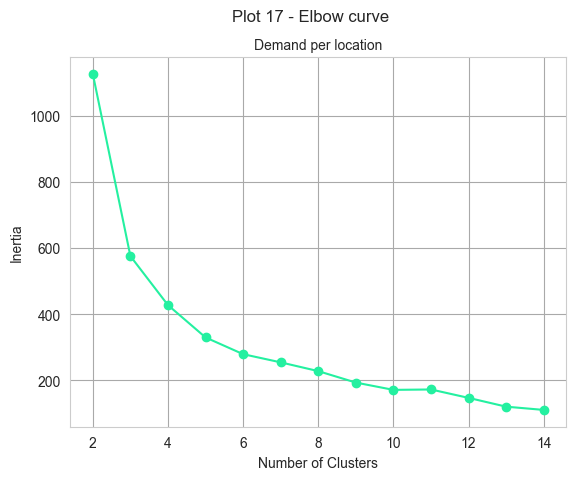

In [33]:
locations = data_wo_outliers[['start_lat_2', 'start_lng_2']]

K_clusters = range(2, 15)
inertia = [KMeans(n_clusters=i).fit(locations).inertia_ for i in K_clusters]

# Plot for Demand per location
plt.plot(K_clusters, inertia, marker='o')
plt.title('Demand per location', fontsize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')


# Set a title for the entire plot
plt.suptitle('Plot 17 - Elbow curve', fontsize=12)

plt.show()


In [34]:
## Using K-means clustering
kmeans = KMeans(n_clusters = 5, init ='k-means++', random_state=42)
kmeans.fit(locations) # Compute k-means clustering.
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
pickle.dump(kmeans, open('kmeans_model.pkl', 'wb'))
locations['cluster_labels'] = kmeans.predict(locations)

# Add the cluster_labels column to the initial DataFrame
#locations = pd.concat([locations, locations_scaled['cluster_labels']], axis=1)
locations.head(5)

start_lat_2  start_lng_2  cluster_labels
0       59.408       24.690               3
1       59.442       24.763               1
2       59.435       24.750               1
3       59.407       24.659               2
4       59.435       24.754               1

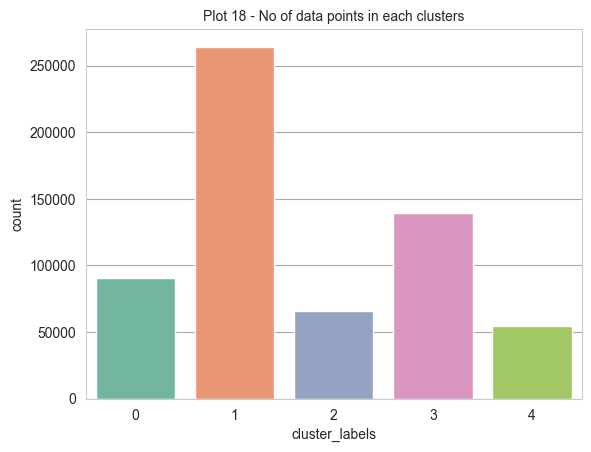

In [35]:
clustered_data = sns.countplot(x=locations['cluster_labels'], palette='Set2')
plt.title('Plot 18 - No of data points in each clusters', fontsize=10)
plt.show()

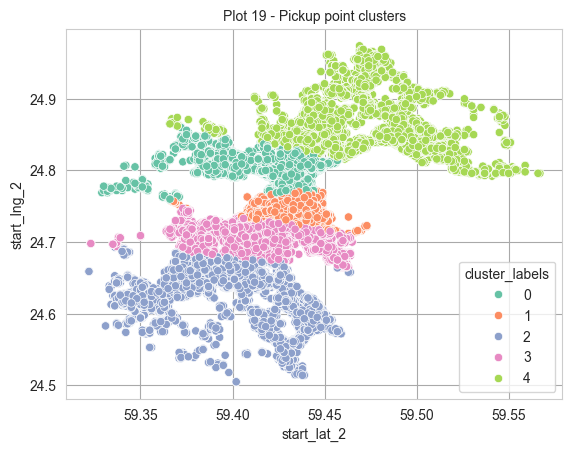

In [36]:
start_location_plot = sns.scatterplot(data = locations, y='start_lng_2', x='start_lat_2', hue='cluster_labels', palette = 'Set2')
plt.title('Plot 19 - Pickup point clusters', fontsize=10)
plt.grid(True, color='darkgray')

<font color='#098f5a'>

**Calculating demand per location cluster on hourly basis for different weekdays.**

This data will be saved and used later to query demand of locations at specific times. 
</font>

In [56]:
demand = data_wo_outliers[['start_lat', 'start_lng', 'start_lat_2', 'start_lng_2', 'hours', 'weekday']].reset_index(drop=True)
locations.reset_index(inplace=True, drop=True)

demand_locations = pd.concat([demand, locations[['cluster_labels']]], axis=1)

demand_locations_stat = pd.DataFrame(demand_locations.groupby(['cluster_labels', 'weekday', 'hours']).size())
demand_locations_stat.rename(columns={0:'demand'}, inplace=True)
demand_locations_stat.reset_index(inplace=True)
demand_locations_stat.to_csv('demand_locations_stat.csv')
print(demand_locations_stat.head())

   cluster_labels  weekday  hours  demand
0               0        0      0     223
1               0        0      1     150
2               0        0      2     148
3               0        0      3     141
4               0        0      4     199


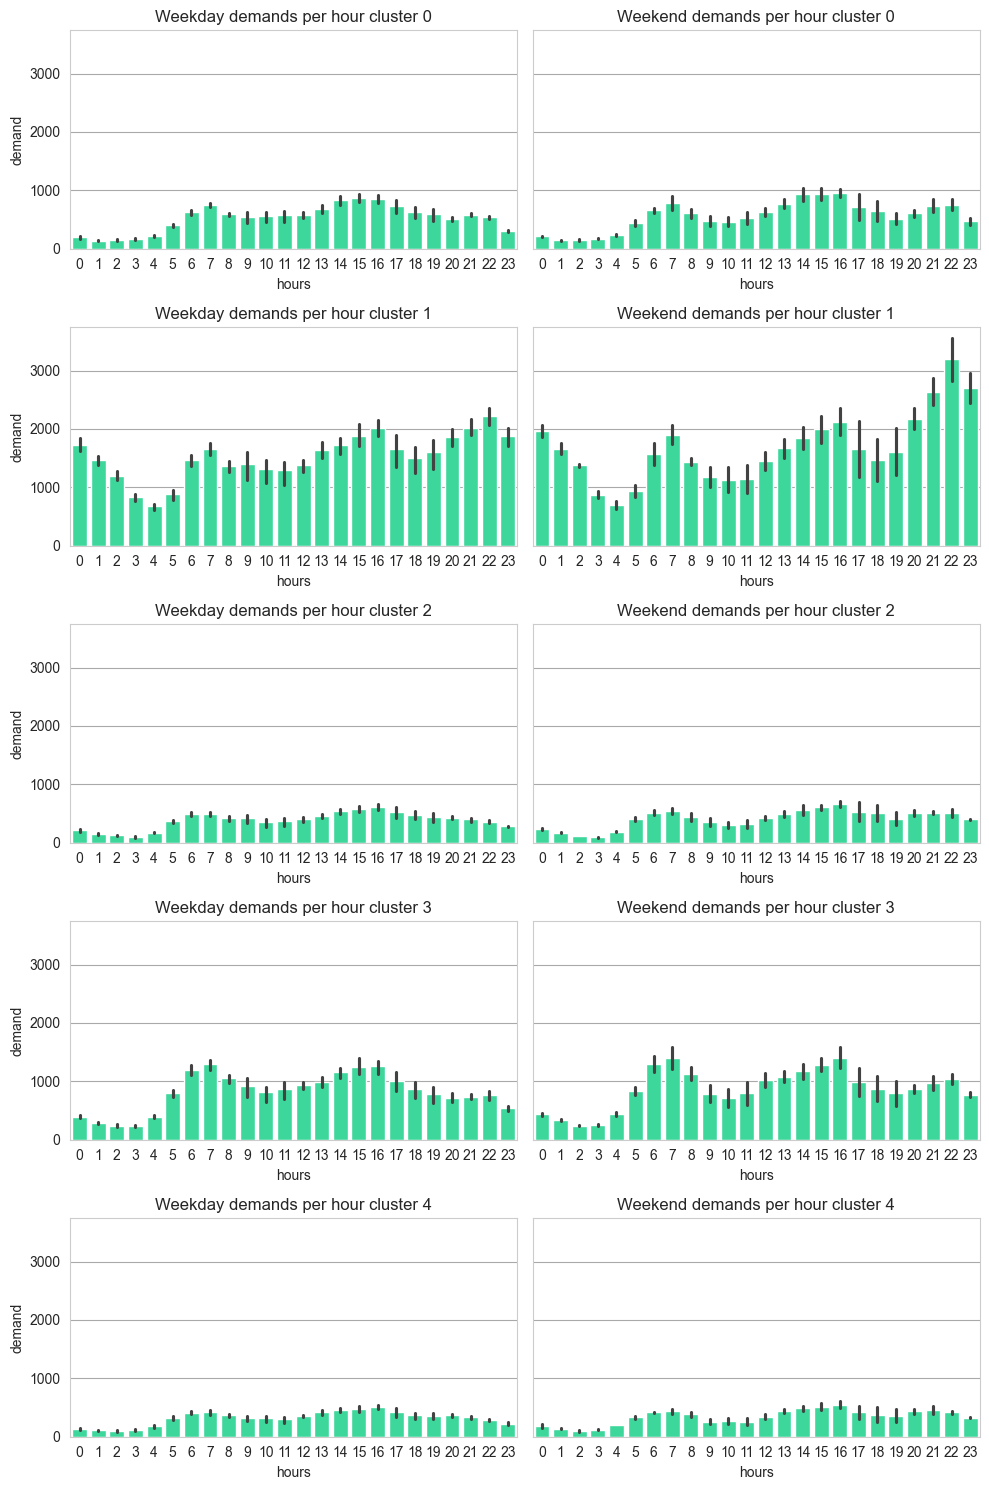

In [53]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharey=True) 

for cluster in demand_locations_stat['cluster_labels'].unique():
    specific_cluster = demand_locations_stat[(demand_locations_stat['cluster_labels']==cluster)]
    axs[cluster][0].set_title('Weekday demands per hour cluster ' + str(cluster))
    axs[cluster][1].set_title('Weekend demands per hour cluster ' + str(cluster))

    weekday_cluster_stats_graph = sns.barplot(data=specific_cluster[specific_cluster['weekday'].isin([0,1,2,3,4])], x='hours', y='demand', ax=axs[cluster][0])
    
    weekend_cluster_stats_graph = sns.barplot(data=specific_cluster[specific_cluster['weekday'].isin([5,6])], x='hours', y='demand', ax=axs[cluster][1])
    
fig.tight_layout() 

<div style="background-color: #82f6c9; padding: 1px;">

<h2>Section 4. Business application</h2>

The application has the following functions:
1. Fetches driver's location with timestamp in real time and extract certain features and preprocess.
2. Runs the saved clustering model to determine in which location cluster the driver is currently situated.
3. Fetches demand of other location cluster at that time and day of the week and calculate location demand ranking.


</div>

In [100]:
def get_driver_info(timestamp, lat, lng):
    driver_info = pd.DataFrame({'timestamp': [timestamp], 'start_lat': lat, 'start_lng': lng})
    driver_info['start_lat'] = driver_info['start_lat'].round(3)
    driver_info['start_lng'] = driver_info['start_lng'].round(3)
    driver_info['hour'] = driver_info['timestamp'].dt.hour
    driver_info['weekday'] = driver_info['timestamp'].dt.weekday
    return driver_info

def get_location_cluster(lat, lng):
    kmeans = pickle.load(open('kmeans_model.pkl', 'rb'))
    cluster_id = kmeans.predict([[lat, lng]])
    return cluster_id[0]

def get_demand(timestamp, lat, lng):
    driver_info = get_driver_info(timestamp, lat, lng)
    print('-------------------------------------')
    print('Driver info: ', driver_info)
    
    # Get the cluster id of the location
    cluster_id = get_location_cluster(driver_info['start_lat'].values[0], driver_info['start_lng'].values[0])
    print('-------------------------------------')
    print('Driver current location cluster id: ', cluster_id)
    print('-------------------------------------')
    
    # Load the demand per hour, per day data summary of each cluster
    demand_locations_stat = pd.read_csv('demand_locations_stat.csv')

    # Extract features related to the time and day of the week
    weekday = driver_info['weekday'].values[0]
    hour = driver_info['hour'].values[0]
    
    # Get the cluster stats relevant to the input data
    current_demand = demand_locations_stat.loc[(demand_locations_stat['hours'] == hour) & (demand_locations_stat['weekday'] == weekday)]
    current_demand.sort_values(by='demand', inplace=True, ascending=False)
    current_demand['relative_demand'] = current_demand['demand'] / current_demand['demand'].abs().max()
    current_demand.drop(columns={'Unnamed: 0'}, inplace=True)
    
    return current_demand_df


# Testing on dummy data (how it will work in actual scenario)
timestamp = pd.to_datetime(data_wo_outliers['start_time']).values[0]
start_lat = data_wo_outliers['start_lat'].values[0]
start_lng = data_wo_outliers['start_lng'].values[0]

current_demand_df = get_demand(timestamp, start_lat, start_lng)
print('Demand in other clusters at this time:')
print(current_demand_df)


-------------------------------------
Driver info:                     timestamp  start_lat  start_lng  hour  weekday
0 2022-03-06 15:02:39.329452     59.408      24.69    15        6
-------------------------------------
Driver current location cluster id:  3
-------------------------------------
Demand in other clusters at this time:
     cluster_labels  weekday  hours  demand  relative_demand
327               1        6     15    1764         1.000000
663               3        6     15    1172         0.664399
159               0        6     15     829         0.469955
495               2        6     15     564         0.319728
831               4        6     15     453         0.256803


<div style="background-color: #82f6c9; padding: 1px;">

<h2>Section 5. Wrapping up</h2>

The following has been done:

1. ***Explore the data and suggest a solution to guide the drivers towards areas with higher expected demand at given time and location***
<br>In this notebook, data exploration has been done **(Section 2: Data Analysis)** to understand the dataset, detecting anomalies and outliers, creating features and then build a clustering algorithm **(Section 3: Demand modelling)** and finally a business application that calculates demand on different areas given a specific time and day **(Section 4: Business Application)**.
   
2. ***Build and document a baseline model for your solution***
<br>This is showcased in **Section 3: Demand Modelling**.
   
3. **Describe how you would design and deploy such a model**
<br>There are many different ways to design a model for predicting demand. For this prototype, a simple pickup location based clustering approach is selected along with historical trip ranking for each location cluster. However, there are other ways to solve this problem, possibly with additional data, some of which are as follows:
    1. Calculate demand based on ride values of trips starting in a specific location cluster.
    2. Enrich model by considering weather forecast data, holidays and special events like sports, concerts, etc.
    3. Extract points of interests like hotels, airports, movie theatres, clubs, etc. and extract features accordingly.
    4. Forecase supply (driver availability) on different time of days or weeks and allocate existing drivers accordingly.
    5. Neural networks and forecasting models could be tried.
    6. [Spatiotemporal forecasting models](https://www.sciencedirect.com/science/article/abs/pii/S0968090X20305805) could be used for comparison.

4. ***Describe how to communicate model recommendations to drivers***
<br>Devices of connected drivers will initiate a POST request to the cloud-hosted REST API with two parameters: the timestamp of the request and the current location. Subsequently, the REST API will perform the following actions:

   1. Utilize the location value to determine the cluster label by leveraging a pre-trained KMeans model stored in the database.
   2. Extract pertinent information, such as the day of the week, hour, by parsing the timestamp parameter.
   3. Retrieve the previously stored dataset containing demand statistics for all clusters from the database. This dataset will be filtered based on the weekday and hour, resulting in the demands of all clusters at the specified time and location.
   4. Utilize the obtained data to generate a color map, highlighting regions of all clusters based on their demand. A darker color in a cluster region indicates a higher demand in that specific area. On the driver's app, [this kind of visualization](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*ZJ85dvxKy1ixIOFS33JoHQ.png) could be implemented for easy understanding.

5. ***Think through and describe the design of the experiment that would validate your solution for live operations taking into account marketplace specifics***
<br>To validate the solution, A/B testing could be implemented with certain target groups get the recommendation and others don't. Top KPIs to validate could be, number of trips per day, average idle time of drivers *(time in between the end of one trip and getting a new request)*, average waiting time of passengers after requesting a cab, etc. 

-----------------------------------------------END------------------------------------------------

</div>